아래의 코드는 Gain/Dynamics 상태를 감지합니다.

다음과 같은 단계로 이루어져 있습니다:

> 1. 필요한 라이브러리와 사용자 정의 모듈을 불러옵니다.

> 2. 데이터 파일 경로를 설정합니다.

> 3. 결과를 저장하기 위한 함수를 정의합니다.

> 4. 훈련 데이터와 테스트 데이터를 불러옵니다.

> 5. 훈련 데이터를 사용하여 Configuration을 계산하고 저장합니다.

> 6. 시험용 데이터를 사용하여 Dynamics/Gain Monitoring을 실행합니다.

In [1]:
# 필요한 라이브러리들을 불러옵니다.
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm

# 상위 디렉토리로 경로를 설정합니다.
sys.path.append(os.path.abspath('../'))

# 사용자 정의 모듈을 불러옵니다.
from classify_fault.set_config import calculate_variables_config
from classify_fault.check_dynamics import *

In [2]:
data_path = '../data/TemperatureTrain.csv'
data_path2 = '../data/Temperature.csv'
config_save_path = '../config/example_config.json'

In [3]:
# 훈련 데이터와 테스트 데이터를 불러옵니다.
train_data = pd.read_csv(data_path, index_col=[0])
test_data = pd.read_csv(data_path2, index_col=[0])
tag_list = train_data.columns.to_list()
test_tag_list = ['temp5Gain']

In [4]:
train_data[tag_list].head()

,temp5
DateTime,
2022-08-01 00:00:00,1220.54
2022-08-01 00:10:00,1210.31
2022-08-01 00:20:00,1206.14
2022-08-01 00:30:00,1200.39
2022-08-01 00:40:00,1204.22


In [5]:
test_data[test_tag_list].head()

,temp5Gain
DateTime,
2023-01-01 00:00:00,1192.58
2023-01-01 00:01:00,1193.04
2023-01-01 00:02:00,1193.46
2023-01-01 00:03:00,1192.96
2023-01-01 00:04:00,1190.98


In [6]:
# 훈련 데이터를 사용하여 Configuration을 계산합니다.
config = calculate_variables_config(tag_list=tag_list, data=train_data[tag_list].values)
dynamic_threshold = config[tag_list[0]]['dynamic_threshold']
tracking_size = config[tag_list[0]]["tracking_size"]

In [8]:
# 각 데이터 포인트에 대한 평균 차이를 저장할 리스트
average_diffs = []
# 감지된 동적 상태를 저장할 리스트
detecteds = []

# 트래킹 사이즈부터 테스트 데이터의 끝까지 반복
for i in range(tracking_size, len(test_data)):
    # 현재 인덱스를 기준으로 트래킹 사이즈만큼 이전의 테스트 데이터를 슬라이싱합니다.
    test_ = test_data[test_tag_list].values[i - tracking_size + 1: i + 1 , :]

    # 동적 상태를 감지하는 함수를 호출하고 결과를 저장합니다.
    dynamics_detected, avg_diff = detect_dynamics(data=test_, 
                                                dynamic_threshold=dynamic_threshold, 
                                                n=tracking_size)
    # 동적 상태가 감지된 경우, detecteds 리스트에 현재 테스트 데이터를 추가합니다.
    if dynamics_detected:
        detecteds.append(test_[-1])
    # 동적 상태가 감지되지 않은 경우, detecteds 리스트에 None 값을 추가합니다.
    else:
        detecteds.append(None)

    # 평균 차이 값을 average_diffs 리스트에 추가합니다.
    average_diffs.append(avg_diff)

c:\Users\asdm1\Anaconda3\envs\techdas\lib\site-packages\numpy\ma\core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


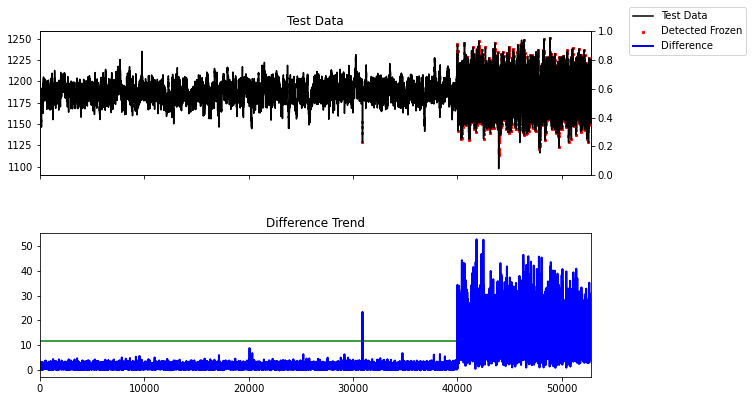

In [9]:
# 시각화
import matplotlib.pyplot as plt
test_data_list = list(test_data[test_tag_list].values.flatten())

fig, ax = plt.subplots(2,1, figsize=(9, 6), sharex=True)
ax1, ax2 = ax[0], ax[1]
ax12 = ax1.twinx()

ax1.plot(test_data_list, c='k', label='Test Data')
ax1.scatter(x=np.arange(len(detecteds)), y=detecteds, 
            s=5.5, c='r', marker='x',
            label='Detected Frozen')
ax1.set_xlim(0, len(test_data_list))
ax1.set_title("Test Data")

ax2.axhline(y=dynamic_threshold, c='g')
ax2.plot(average_diffs, c='b', label='Difference', linewidth=2)
ax2.set_title("Difference Trend")

fig.legend(loc='center', bbox_to_anchor=(1.10, 0.9))  # Set the legend location
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.95, hspace=0.4)
plt.show();